## Introduction 

"Vector Quantization." Sounds intimidating. "Residual Vector Quantization" sounds even more intimidating, even near-meaningless to most people. Turns out, these are easy to understand given a few pictures, even to the point a child could understand them -- uh... if the child *wanted* to.  Certainly, there can be sophisticated ways to implement these algorithms, and we'll cover a bit of that later on, but the basics are very simple.

Residual Vector Quantization (RVQ) is a [data compression](https://www.instagram.com/p/CteX0esglU-/) technique found in state-of-the-art neural audio codecs such as Google's [SoundStream](https://ai.googleblog.com/2021/08/soundstream-end-to-end-neural-audio.html), and Facebook/Meta AI's [Encodec](https://github.com/facebookresearch/encodec), which in turn form the backbone of generative audio models such as [AudioLM](https://google-research.github.io/seanet/audiolm/examples/) (Google) and [MusicGen](https://ai.honu.io/papers/musicgen/) (Facebook).  It's also the subject of Lucidrain's library [`vector-quantize-pytorch`](https://github.com/lucidrains/vector-quantize-pytorch), which we'll use toward the end because it's *so fast* and *so good*. 


What is RVQ and how does it work?  

First we should consider regular vector quantization (VQ). VQ has been around for decades, and it shows up in many areas of signal processing when compression is involved. 

> Note: Whenever I say something that applies to both VQ and RVQ, I'll use the abbreviation "(R)VQ." 

::: {.callout-tip}
# Tip: Two Analogies

1. **Cities and Towns:** RVQ is like a "hub-and-spoke" *graph* that often appears in logistics: Consider air travel, in which the major cities are "hubs" (Chicago, LA, Atlanta) from which you take smaller flights to get to smaller cities and towns.  VQ would be like replacing every address with its nearest town -- which could result in a lot of vectors! RVQ means we have a short list of hubs, then from each hub we have a list of smaller cities, from which we could then have lists connecting smaller cities to nearby towns. 

2. **Numbers and Digits:** In one dimension, RVQ is like the way we represent numbers using digits. Instead of creating 10,000 separate categories for each of the integers from 0 to 9999, we use 4 “codebooks” (for thousands, hundreds, tens, and ones) consisting of the ten digits 0 through 9. 4 * 10 = 40, which is a lot less than 10,000! We even can represent real numbers to arbitrary precision by using more codebooks to include ever-smaller "residual vectors" to the right of the decimal point. 
:::

## Vector Quantization = Partitioning Space

"Vector Quantization" is really about dividing up the space of your data points into a discrete set of regions.  Put differently, we "partition" the space. 

Let's say we have a bunch of points in space:

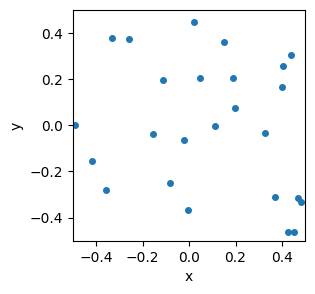

In [ ]:
#| code-fold: true
#| code-summary: "Show the code"
#| label: fig-dots
#| fig-cap: "A set of data points, aka 'vectors'."


import numpy as np 
import matplotlib.pyplot as plt

# make some data
n_points = 25
DATA_MIN, DATA_MAX = -0.5, 0.5 # we'll let these be globals
np.random.seed(9)  # for reproducibility
data = DATA_MIN + (DATA_MAX-DATA_MIN)*np.random.rand(n_points, 2)

# plot it
fig, ax = plt.subplots(figsize=(3,3))
ax.set_xlim(DATA_MIN, DATA_MAX)
ax.set_ylim(DATA_MIN, DATA_MAX)
#ax.set_xticks([])  # hide axis ticks
#ax.set_yticks([])
ax.set_xlabel('x')
ax.set_ylabel('y')
plt.scatter(data[:, 0], data[:, 1], s=16)
plt.show()

To computer scientists, the $(x,y)$ coordinates of each point define a "vector".  (To mathematicians and physicists, the "vector" points from the origin to each point, but that distinction isn't going to matter to us.) 

::: {.callout-note}
## Clarification

For neural audio codecs, the vectors could be vertical slices (columns) from an audio spectrogram, i.e., a list of amplitudes for a set of frequencies that were found over a short time interval called a "frame."  More often, however, the vectors are *themselves* the outputs of some other audio encoder (e.g. a Convolutional Neural Network), and the (R)VQ is done to compress *those* encoded vectors even more in order to do things like [Latent Diffusion](https://github.com/CompVis/latent-diffusion). 
:::

Now divide up the space into a bunch of regions.  How we do that can take many forms. For now, just consider the two examples of my hand drawing with colors, and a set of tiled squares. There are "fancier" algorithms to partition the space in a way that best "fits" the data (e.g., see "k-Means", below).  We can cover schemes like the third image later. 

<!--- ::: {layout-ncol=2 label="fig-region-options" fig-cap="Two ways of partitioning space"} -->

::: {#fig-regions2 layout-ncol=3}

![By hand](images/dots_square_handregions.png){#fig-hand}

![Squares](images/dots_squares_basic.png){#fig-lilsquares}

![Fancy (credit: Aalto University, Finland)](images/vq_aalto_sm.png){#fig-lilsquares}


Examples of ways to divide up or "quantize" space, aka "Partitioning schemes."
:::

Moving forward, I can do a bit more code-wise with the squares, so let's start there. ;-)  

Let me just formalize that a bit: We'll let the number of squares be controlled by the variable "`n_grid`". So for our two-dimensional examples, there will be `n_grid`$^2$ square regions. 

With vector quantization, we give an index value to every region (e.g. 0 to 24 for a 5x5 square grid), and then  we ***replace each vector's value with the index of the region***. 

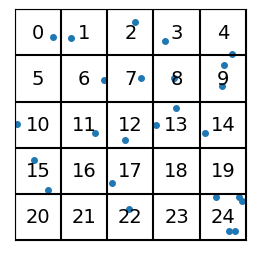

In [ ]:
#| code-fold: true
#| code-summary: "Show the code"
#| label: fig-indices
#| fig-cap: "(Integer) Indices for each region."



#| code-fold: true
#| code-summary: "Show the code"
import pandas as pd 

def plot_data_grid(data, n_grid=5, hide_tick_labels=True, show_indices=False, show_centroids=False, 
                   show_next_level_grid=False):
    "big ol' workhorse plotting routine that we'll progressively make use of as the lesson proceeds"
    fig, ax = plt.subplots(figsize=(3,3))
    h = 1.0 / n_grid
    ax.set_xlim(DATA_MIN, DATA_MAX)
    ax.set_ylim(DATA_MIN, DATA_MAX)

    for i in range(n_grid + 1):
        ax.axhline(DATA_MIN + i*h, color='black')
        ax.axvline(DATA_MIN + i*h, color='black')
        
    if show_indices:
        index = 0
        for j in range(n_grid):
            for i in range(n_grid):
                x = DATA_MIN + (i + 0.5) / n_grid
                y = DATA_MIN + 1 - (j + 0.5) / n_grid
                ax.text(x, y, str(index), ha='center', va='center',fontsize=14)
                index += 1

    if show_centroids: 
        for j in range(n_grid):
            for i in range(n_grid):
                x = DATA_MIN + (i + 0.5)*h
                y = DATA_MIN + (j + 0.5)*h
                ax.plot(x, y, 'ro', markersize=6)
                
    if hide_tick_labels:
        ax.set_xticks([])
        ax.set_yticks([])

    ax.set_aspect('equal')
    if data is not None:
        plt.scatter(data[:, 0], data[:, 1], s=16)
    plt.show()
    
    
n_grid=5
#plot_data_grid(data, n_grid=n_grid)
plot_data_grid(data, n_grid=n_grid, show_indices=True)

For each of the "vectors" represented by the data points, we no longer use the ($x$,$y$) coordinate pairs, but rather the (integer) index of the region it's in. 

::: {.callout-note}
We've gone from needing two floating point numbers per point to just one integer value. In two dimensions, the "savings" or data-compression amount that we get from that may not be readily apparent, but stick around:  As we go to large numbers of dimensions later, this scheme will save us a *ton* of data.
:::

If we want the coordinates that go with the indices, we'll use the centroid of each region.  In this sense, the vectors are "quantized" so that they can only take on values given by the centroids of the regions. In the following example, the centroids are shown in red:

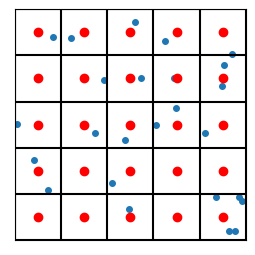

In [ ]:
#| code-fold: true
#| code-summary: "Show the code"
#| label: fig-centroids
#| fig-cap: "Centroid locations"
plot_data_grid(data, n_grid=n_grid, show_indices=False, 
               show_centroids=True)

So each blue point will effectively be replaced by the nearest red point.  In this sense we have "quantized" the vectors (because we've quantized the space itself).

::: {.callout-tip}
## Terminology
The set of locations of centroids is called the "**codebook**". When we want to use an actual vector value (in space), we convert the codebook index into a (centroid) location by looking up the codebook. 
:::

<!--
For reasons of simplicity (/laziness) that will become clear later, for this blog post we'll choose coordinates where our space is centered on (0,0), and has a span of (1,1) across it. So that means the space will go from (-0.5,-0.5) to (0.5,0.5).  This choice of coordinates doesn't change the basic mechanics of (R)VQ, it just means less work to do later. -->

So a full (albeit unweidly) picture showing the data points, the region indices, and the centroids, looks like this: 

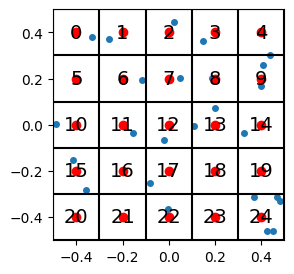

In [ ]:
#| code-fold: true
#| code-summary: "Show the code"
#| label: fig-detailed-squares
#| fig-cap: "Detailed figure showing data points, region indices, and centroid locations."
plot_data_grid(data, n_grid=n_grid, show_indices=True, show_centroids=True, hide_tick_labels=False)

For our choice of coordinates, the codebook (i.e. the mapping of indices to centroid locations) looks like this:

In [ ]:
#| code-fold: true
#| code-summary: "Show the code"

from IPython.display import display, Markdown

def generate_codebook(n_grid, n_dim=2, debug=False):
    n_gridpoints = n_grid ** n_dim
    if debug: print(f"generate_codebook: n_grid = {n_grid}, n_dim = {n_dim}, n_gridpoints = {n_gridpoints}")
    centroids = np.empty((n_gridpoints, n_dim))
    h = (DATA_MAX - DATA_MIN)/n_grid
    for i in range(n_dim):
        coords = np.linspace(DATA_MIN + h/2, DATA_MAX - h/2, n_grid)
        coords = np.tile(coords, int(n_gridpoints / n_grid ** (i + 1)))
        coords = np.repeat(coords, n_grid ** i)
        centroids[:, i] = coords

    return centroids


codebook = generate_codebook(n_grid)


# print it nicely
cb_str = f"| index      | vector |\n| ----------- | ----------- |"
for i in range(codebook.shape[0]):
    cb_str += f"\n| {i} | ({codebook[i,0]:.1f}, {codebook[i,1]:.1f}) |"
display(Markdown(cb_str))

| index      | vector |
| ----------- | ----------- |
| 0 | (-0.4, -0.4) |
| 1 | (-0.2, -0.4) |
| 2 | (0.0, -0.4) |
| 3 | (0.2, -0.4) |
| 4 | (0.4, -0.4) |
| 5 | (-0.4, -0.2) |
| 6 | (-0.2, -0.2) |
| 7 | (0.0, -0.2) |
| 8 | (0.2, -0.2) |
| 9 | (0.4, -0.2) |
| 10 | (-0.4, 0.0) |
| 11 | (-0.2, 0.0) |
| 12 | (0.0, 0.0) |
| 13 | (0.2, 0.0) |
| 14 | (0.4, 0.0) |
| 15 | (-0.4, 0.2) |
| 16 | (-0.2, 0.2) |
| 17 | (0.0, 0.2) |
| 18 | (0.2, 0.2) |
| 19 | (0.4, 0.2) |
| 20 | (-0.4, 0.4) |
| 21 | (-0.2, 0.4) |
| 22 | (0.0, 0.4) |
| 23 | (0.2, 0.4) |
| 24 | (0.4, 0.4) |

### Reconstruction Error 

When we do this quantization (i.e. replacing vectors by their nearest centroid), the centroid locations will naturally be a bit "off" compared to the original data vectors themselves.  The finer the grid you make, the smaller the regions, and the less error.  For a 2D grid, the error will be on the order of $h^2$ where $h$ is the grid spacing ($h$ = 1/5 = 0.2 in our example).


::: {.callout-note}
Note that the vectors in the codebook are *not* "basis vectors": We do not add linear combinations of the codebook vectors, as that would not be "quantization" (and would subject us to the same number of data points
as the original, resulting in nearly no compression). VQ helps us get around some problems of having large numbers of data points by approximating them by their nearest codebook vectors, and the R in RVQ allows us to increase the provide for good "resolution" within the space *without* requiring extremely long codebooks. 
:::


Let's check how the error changes as we vary the grid spacing, i.e., as we vary `n_grid`. 

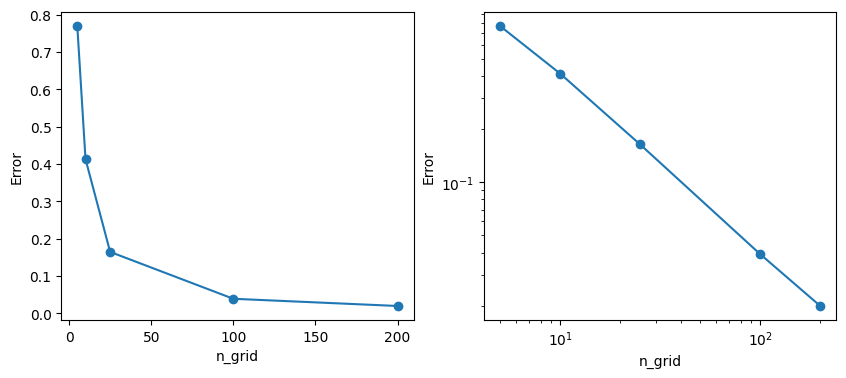

lowest error (for n_grid=200) =  0.019903707672610238


In [ ]:
#| code-fold: true
#| code-summary: "Show the code"
#| label: fig-error
#| fig-cap: "Plots of error vs. resolution with linear (left) and logarithmic (right) axes. Note that the computational cost will scale like the number of regions, which is `n_grid`$^2$."
def find_closest_centroids(data, codebook):
    distances = np.sum((data[:, np.newaxis] - codebook) ** 2, axis=2)
    closest_centroids = np.argmin(distances, axis=1)
    return closest_centroids # indices not coordinates

def compute_error(data, codebook):
    n_grid = int(np.sqrt(codebook.shape[0]))
    h = 1/n_grid * (DATA_MAX - DATA_MIN) 
    quantized_ind = find_closest_centroids(data, codebook)
    quantized_xy = codebook[quantized_ind]       
    error = np.sqrt( np.sum( (data - quantized_xy)**2 ) )
    return error 

n_points2 = 100
data2 = DATA_MIN + (DATA_MAX - DATA_MIN)*np.random.rand(n_points2, 2)

errors = []
grids = np.array([5,10,25,100,200])
for n_grid2 in grids:
    codebook = generate_codebook(n_grid2)
    error = compute_error(data2, codebook)               
    errors.append(error)
    
fig, ax = plt.subplots(1,2, figsize=(10,4))    
ax[0].plot(grids, errors, 'o-')
ax[1].loglog(grids, errors, 'o-')
for i in range(2):
    ax[i].set_ylabel('Error')
    ax[i].set_xlabel('n_grid')
plt.show()
print(f"lowest error (for n_grid={grids[-1]}) = ",errors[-1])


So, the more "gridlines" you use, the lower the error, but at what cost?  To get an error of 0.02 we need $200^2 = 400$ regions. And in higher dimensions than 2, the "cost" of higher resolution / lower error goes up *immensely*: to double the resolution in $d$ dimensions, the computational cost goes up by a factor of $2^d$. (Imagine $d$=32, 64, 128,...) 

But we don't need to cover the entire space uniformly! That's where Residual Vector Quantization comes in. Feel free to skip ahead to the section on RVQ. For the next bit we'll take an optional aside to learn about an alternate way to partition space, known as a the "k-Means" algorithm. 


::: {.callout-note}
Another key point: By replacing all the coordinate values for a vector (i.e. $d$ floating point numbers) with a *single integer*, VQ achieves data compression by a factor of $d$ (times however many bit floats take up compared to integers).  For large numbers of dimensions -- regardless of the partitioning scheme -- this compression can be *significant*.
:::

### k-Means (Partitioning Scheme)

::: {.callout-caution}
## Optional 
This discussion on k-Means is actually not crucial to understanding (R)VQ.  At all. It's quite skippable, to be honest.  So...only read if you're really curious. Otherwise skip down to the section on [Residual Vector Quantization](#residual-vector-quantization-rvq).
:::

<details><summary>Details on k-Means</summary>

The k-Means algorithm is another method to partition space, a method that 
instead of static squares, will allow our regions and centroids to "follow the data". Often k-Means is used to *initialize* an RVQ codebook for neural codecs (e.g. in SoundStream, Encodec, etc), after which the rest of the neural network's training algorithm may refine the codebooks more. 



We'll start with a bunch of data points shown as small dark circles below, and a set of $k$ "centroids" shown by the large colored circles.  (They're not actually "centroids" yet but we'll get there).

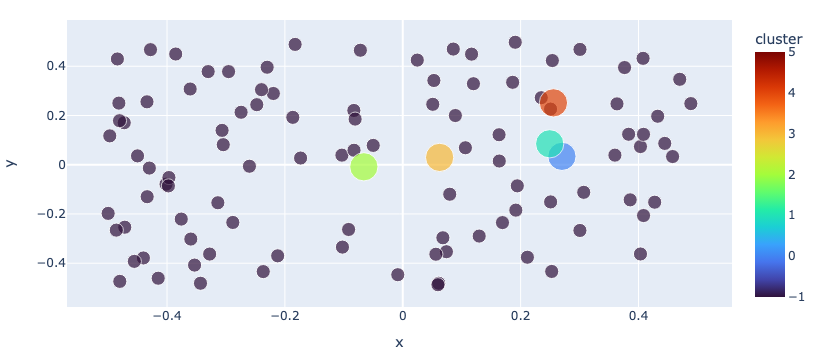

In [ ]:
#| code-fold: true
#| code-summary: "Show the code"
#| label: fig-kmeans-init
#| fig-cap: "Initial state of k-Means, showing data without any 'membership' (dark dots) and random centroid locations (large colored dots)"
# lots of imports to try to get the plotly plots and animations to show!
import plotly.io as pio
pio.renderers.default='notebook'
import plotly.express as px 
from plotly.offline import plot, iplot, init_notebook_mode
import plotly.graph_objs as go
init_notebook_mode(connected=True)


ndim = 2  # easier to do in 2d at first
npoints = 100
np.random.seed(1)
datak = DATA_MIN + (DATA_MAX-DATA_MIN)*np.random.rand(npoints, ndim)   # make up some random data points

k = 5        # k-Means parameter: number of clusters

# start with random centroids
centroids = DATA_MIN + 0.2+0.6*(DATA_MAX-DATA_MIN)*np.random.rand(k, ndim) # don't let the starting centroids be on the far edges of the plot
orig_centroids = centroids.copy() # save these for later when we'll make a movie


def plot_kmeans(data, centroids, cluster_memb=None): # we'll leave a way to color the data points
    all_data = np.concatenate((data,centroids))
    is_centroid = np.array( [1 if i >= npoints else 0 for i in range(all_data.shape[0])] , np.newaxis)
    sizes = is_centroid*3 + 1
    cs = cluster_memb if cluster_memb is not None else -1+np.zeros( (data.shape[0],1) ,dtype=int) 
    cs = np.append(cs, range(k)) # add the centroids
    plot_data = np.column_stack( (all_data, sizes, cs) )
    columns = ['x','y','sizes','cluster']
    df = pd.DataFrame( plot_data,  columns=columns)
    fig = px.scatter(df, x="x", y="y", color='cluster', size='sizes',  range_color=(-1,k),
            width=420, height=360, color_continuous_scale='Turbo')
    fig.update_layout(margin=dict(l=20, r=20, t=20, b=20),)#template='plotly_dark',)
    return fig

plot_kmeans(datak, centroids)
    

That's our starting points.  Then what we'll do is, we'll color each point according to which centroid it's closest to. 

:::{.callout-warning}
Yes, this can be *very slow* for lots of points in many dimensions. There is a whole field of study of how to speed up "nearest neighbors" types of algorithms.  We're going to keep it simple for this demo. Further down,
the library we'll use will actually do an "approximate k-Means" for speed. 
:::

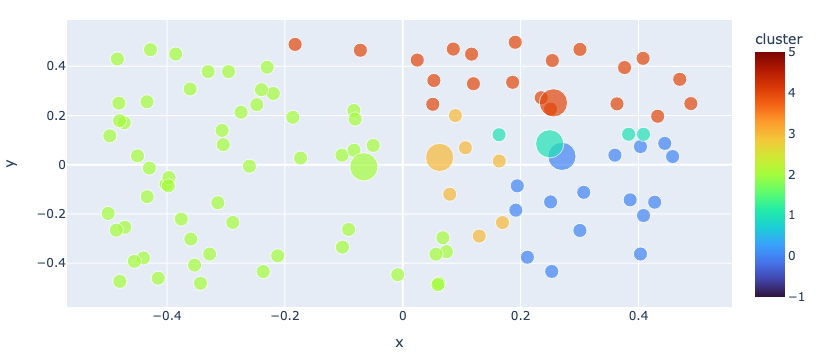

In [ ]:
#| code-fold: true
#| code-summary: "Show the code"
#| label: fig-kmeans-first
#| fig-cap: "First step in k-Means: Assign 'membership' of datapoints to different clusters based on which centroids (large dots) are nearest. Note that the 'centroids' in this graph aren't true centroids yet. We'll fix them in the next step after this."

def distance(p1, p2):
    "euclidean distance squared. we don't need the square root b/c we're only interested in ordering by distance"
    return np.sum((p1-p2)**2, axis=1)

def calc_cluster_membership(data, centroids):
    npoints = data.shape[0]
    min_ds = 9999*np.ones(npoints)
    cluster_memb = np.zeros(npoints, dtype=int)-1
    for i, c in enumerate(centroids): # compute distances for all points
        ds = distance(data, c)
        inds = np.argwhere(ds < min_ds)
        if inds.size > 0: 
            min_ds[inds] = ds[inds]
            cluster_memb[inds] = i
    assert len(cluster_memb)==npoints # we're not including the centroids themselves here
    return cluster_memb

cluster_memb = calc_cluster_membership(datak, centroids)
plot_kmeans(datak, centroids, cluster_memb=cluster_memb)

The next step is to recalculate the centroid locations using the points that were assigned to each centroid. And these centroids are just the mean value of the points. 

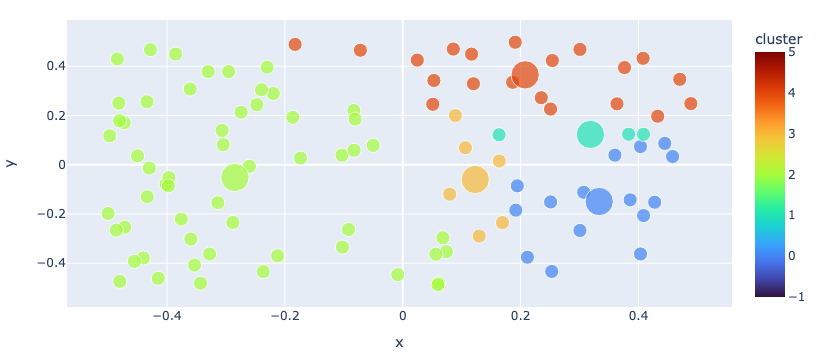

In [ ]:
#| code-fold: true
#| code-summary: "Show the code"
#| label: fig-kmeans-centroids
#| fig-cap: "Next step in k-Means: move centroids so they are in the middle of each cluster"

def move_centroids(centroids, data, cluster_memb):
    for ki in range(centroids.shape[0]):
        inds = np.argwhere( cluster_memb == ki)
        if inds.size > 0:
            for dim in range(data.shape[-1]):
                centroids[ki,dim] = np.mean(data[inds,dim], axis=0)
    return centroids

centroids = move_centroids(centroids, datak, cluster_memb)
#print("These centroids should be fairly 'centered' in their respective groups of data.")
plot_kmeans(datak, centroids, cluster_memb=cluster_memb)

...But now, having moved the centroids, the nearest-neighbor membership of some of the points may have changed. 
So we recalculate those:

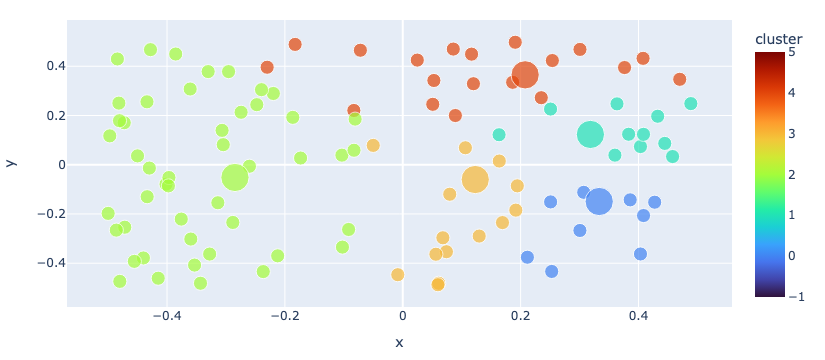

In [ ]:
#| code-fold: true
#| code-summary: "Show the code"
#| label: fig-kmeans-re-member
#| fig-cap: "Next step in k-Means: re-assign cluster membership of point based on new cluster locations"

cluster_memb = calc_cluster_membership(datak, centroids)
plot_kmeans(datak, centroids, cluster_memb=cluster_memb)

...And we repeat the process until some stopping criterion is met. For example we may just set a maximum iteration number, or we may stop when the centroids stop moving, or the cluster membership stops changing, etc. 
For this demo, we'll just use a maximum number of iterations. 

So, a movie of the whole process can look like this: 

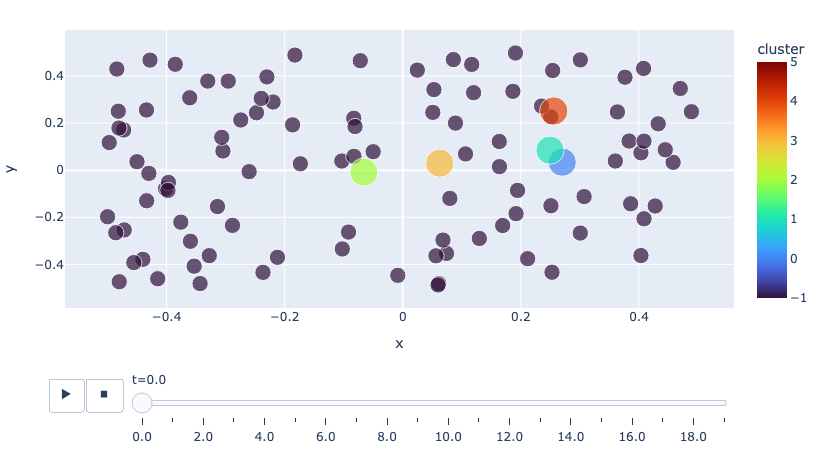

In [ ]:
#| code-fold: true
#| code-summary: "Show the code" 
#| label: fig-kmeans-movie
#| fig-cap: "(Interactive) In this movie, each time step is either the 'cluster membership' step or the 'centroid moving' step."


centroids = orig_centroids.copy() # start over
cluster_memb = -1+np.zeros( (datak.shape[0],1) ,dtype=int) 
maxiter = 10
plot_kmeans(datak, centroids, cluster_memb=cluster_memb)
ts = np.arange(2*maxiter,dtype=int)

columns = ['t','x','y','sizes','cluster','point_number']
total_points = npoints + k  # points + clusters
movie_data = np.zeros( (len(ts)*total_points, len(columns)) )  # giant data array for all data points at all times
movie_data[:,0] = np.repeat(ts, total_points)          # t

xs = np.concatenate( ( datak[:,0], centroids[:,0] ) ) # initial xs
ys = np.concatenate( ( datak[:,1], centroids[:,1] ) ) # initial ys
movie_data[:,1] = np.tile(xs, len(ts))
movie_data[:,2] = np.tile(ys, len(ts))

sizes = np.ones(total_points,dtype=int)
sizes[-k:] = 3
movie_data[:,3] = np.tile(sizes, len(ts)) # sizes is repeated for all times

cs = -2 + np.ones(total_points,dtype=int)
cs[-k:] = np.arange(k, dtype=int)
movie_data[:,4] = np.tile(cs, len(ts))

movie_data[:,5] = np.tile(np.arange(total_points), len(ts))  # point_number is repeated for all time

for t in ts:
    if t==0: 
        continue # leave initial data as step 0
    elif t % 2 == 1: 
        cluster_memb = calc_cluster_membership(datak, centroids)
    else:
        centroids = move_centroids(centroids, datak, cluster_memb)

    start, end = t*total_points, (t+1)*total_points  
    movie_data[start:end, 1] = np.concatenate( (datak[:,0], centroids[:,0]) )    # xs
    movie_data[start:end, 2] = np.concatenate( (datak[:,1], centroids[:,1]) )    # ys
    movie_data[start:end, 4] = np.concatenate( (cluster_memb, np.arange(k, dtype=int)) )  # cluster membership
    
    
df = pd.DataFrame(movie_data, columns=columns)
#df['cluster'] = df['cluster'].astype(int).astype(str) # use discrete colormap
#display(df)


fig = px.scatter(df, x="x", y="y", animation_frame="t", animation_group="point_number",
           color="cluster", hover_name="cluster", hover_data=['point_number'],
           size='sizes', width=420, height=460, range_color=(-1,k), color_continuous_scale='Turbo'
           )
fig.update_layout( margin=dict(l=20, r=20, t=30, b=10),)# template='plotly_dark',)
fig.layout.updatemenus[0].buttons[0].args[1]["transition"]["duration"] = 0 # don't interpolate frames
display(fig)
#print( "Caption: In this movie, each step will either be the 'membership' step or \nthe 'centroid moving' step.")

For those who are interested, I'll put the code for a working k-Means algorithm below -- it's short!

In [ ]:
def kmeans(data, k=5, n_iter=8):
    n_dim, data_min, data_max = data.shape[-1], np.min(data), np.max(data)
    centroids = data_min + 0.2+0.6*(data_max-data_min)*np.random.rand(k, n_dim) # random init
    for it in range(n_iter):
        cluster_memb = calc_cluster_membership(data, centroids)
        centroids = move_centroids(centroids, data, cluster_memb)

    return centroids, cluster_memb

The end result of k-Means, since it is a kind of "nearest neighbors" algorithm, is set of vectors grouped according to a "[Vornonoi diagram](https://mathworld.wolfram.com/VoronoiDiagram.html)" like the one shown near the beginning of this post, which we'll show again for good measure: 

::: {#fig-regions-kmeans}

![](images/vq_aalto_sm.png)

Space partitioning that can result from k-Means. (Credit: [Aalto University, Finland](https://speechprocessingbook.aalto.fi/Modelling/Vector_quantization_VQ.html))
:::


</details>

## Residual Vector Quantization (RVQ)

:::{callout-note}
By the way, RVQ has been around for [quite a while](https://ieeexplore.ieee.org/abstract/document/480761).
:::

### Basic Idea: "Codebooks in Codebooks"

The trick with RVQ is, rather than having a single high-resolution codebook, to instead have "codebooks inside of codebooks", or, if you like, "stacking codebooks".  Let's say we want to quintuple the resolution of our initial 5x5 grid.  Instead of using a 25x25 grid (which would be 25x the computational cost of the original), what if we put a little 5x5 grid "inside" the region to which a vector was quantized? 

For example, in the "middle" region (region 12), we can do...

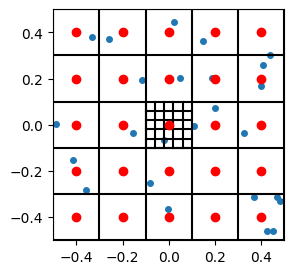

In [ ]:
#| code-fold: true
#| code-summary: "Show the code"
#| label: fig-rvq-basic
#| fig-cap: "Illustration of 'codebook within a codebook', with a smaller 5x5 codebook which will be relative to the middle region's codebook."

from matplotlib import collections  as mc


def get_region_membership(data:np.array, h=0.2, codebook=None):
    "Tells which region each point is in. TBD: this is slow but it works! ;-) "
    memb = np.zeros(data.shape[0], dtype=np.int32)
    if codebook is None:  # just assume basic squares
        for di, p in enumerate(data):
            i = (p[0]-DATA_MIN) // h
            j = (p[1]-DATA_MIN) // h
            ind = i + j*n_grid
            memb[di] = ind
    else: 
        memb = calc_cluster_membership(data, codebook)
    return memb


def plot_data_grid_with_resids(data, n_grid=5, hide_tick_labels=True, show_indices=False, show_centroids=False, 
                   show_next_level_grid=False, show_resids=True, codebook=None, show_grid=True):
    "big ol' workhorse plotting routine that we'll progressively make use of as the lesson proceeds"
    fig, ax = plt.subplots(figsize=(3,3))
    h = 1.0 / n_grid
    ax.set_xlim(DATA_MIN, DATA_MAX)
    ax.set_ylim(DATA_MIN, DATA_MAX)

    if show_grid:
        for i in range(n_grid + 1):  
            ax.axhline(DATA_MIN + i*h, color='black')
            ax.axvline(DATA_MIN + i*h, color='black')
        
    if show_next_level_grid: # draws lines in the middle
        x_start = 2*h
        y_start = -h/2
        for i in range(n_grid): # horizontal lines
            y = y_start + i*h/n_grid
            ax.axhline(y, xmin=x_start, xmax=x_start+h, color='black')
        y_start, x_start = x_start, y_start
        for j in range(n_grid): # horizontal lines
            x = x_start + j*h/n_grid
            ax.axvline(x, ymin=y_start, ymax=y_start+h, color='black')
        
    if show_indices:
        index = 0
        for j in range(n_grid):
            for i in range(n_grid):
                x = DATA_MIN + (i + 0.5) / n_grid
                y = DATA_MIN + 1 - (j + 0.5) / n_grid
                ax.text(x, y, str(index), ha='center', va='center',fontsize=14)
                index += 1

    if show_centroids: 
        for j in range(n_grid):
            for i in range(n_grid):
                x = DATA_MIN + (i + 0.5)*h
                y = DATA_MIN + (j + 0.5)*h
                ax.plot(x, y, 'ro', markersize=6)
                
    if show_resids and codebook is not None:
        memb = get_region_membership(data, codebook=codebook)
        resids = data*0
        lines = []
        for i, p in enumerate(data):
            #resids[i] = p - codebook[memb[i]] # don't actually need to compute resids for this
            lines.append([p, codebook[memb[i]] ] )
        lc = mc.LineCollection(lines, colors=(1,0,1,1), linewidths=2)
        ax.add_collection(lc)
        
    if hide_tick_labels:
        ax.set_xticks([])
        ax.set_yticks([])

    ax.set_aspect('equal')
    if data is not None:
        plt.scatter(data[:, 0], data[:, 1], s=16)
    plt.show()
    
    
n_grid=5
codebook = generate_codebook(n_grid)
plot_data_grid_with_resids(data, n_grid=n_grid, show_next_level_grid=True, show_centroids=True, 
                           hide_tick_labels=False, codebook=codebook, show_resids=False)


The difference between that blue point in the middle "main" square and its corresponding red centroid will be the "residual". We will also quantize that within the "little" 5x5 grid. This will serve as a codebook to use "after" the original codebook.  And we'll get the same resolution as if we had a 25x25 grid, except our computational cost will instead be 2\*(5\*5)=50 instead of 25\*25=625!  So our cost will be 12.5 smaller than the full-grid approach. 

And interestingly, if we only consider the *residual*, i.e. the difference between the main centroid and the vector in question, then we can use the same "next level" codebook for *all* points in the space! 
In the following figure, we show the residuals as purple line segments that run from each point to its corresponding nearest centroid:

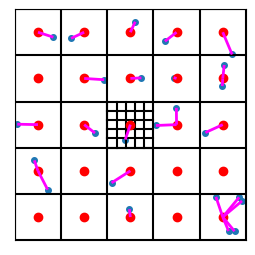

In [ ]:
#| code-fold: true
#| code-summary: "Show the code"
#| label: fig-rvq-resids
#| fig-cap: "Illustration of redisuals, shown as purple line segments connecting vectors (blue points) with their nearest centroids (red points)."
plot_data_grid_with_resids(data, n_grid=n_grid, show_next_level_grid=True, show_centroids=True, 
                           hide_tick_labels=True, codebook=codebook, show_resids=True)

Also, because we cleverly set up our data to be centered around the origin $(0,0)$, we can treat the original data points as "residuals" relative to the "centroid" of the whole domain, namely the origin!

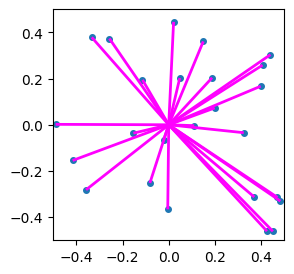

In [ ]:
#| code-fold: true
#| code-summary: "Show the code"
#| label: fig-rvq-zero
#| fig-cap: "How we can treat the data points themselves as residuals relative to the origin, for a 'level 0' codebook"
plot_data_grid_with_resids(data, n_grid=n_grid, show_next_level_grid=False, show_centroids=False, 
                           hide_tick_labels=False, codebook=np.zeros((data.shape[0],2)), show_resids=True, show_grid=False)

Also because of our clever choice of coordinates,  for the next "level" of quantization, we can take the codebook at the next level to be just the previous codebook divided by `n_grid`!  This won't always be the case; I'm just feeling clever and lazy. 

### Quantizer algorithm
Up til now, we've hidden the code by default.  But to really get the RVQ method, I'm going to show the code. 

Let's write a general quantizer multiple "levels" of nested codebooks. It will take our data points and return the various levels of codebook indices. 

Will be following "Algorithm 1" from page 4 of Google's 2021 paper "[SoundStream: An End-to-End Neural Audio Codec](https://arxiv.org/abs/2107.03312)":

::: {#fig-soundstream-alg1}

![](images/soundstream_alg1.png)

SoundStream's RVQ Algorithm
:::

But I like the way I write it: 

In [ ]:
def quantizer(data, codebooks, n_grid=5):
    "this will spit out indices for residuals in a series of 'nested' codebooks"
    resids = data 
    indices = []
    for cb in codebooks:
        indices_l = get_region_membership(resids, codebook=cb)
        resids = resids - cb[indices_l]
        indices.append(indices_l)
    return np.array(indices)

# Make the nested codebooks
n_codebooks = 3
codebook = generate_codebook(n_grid)
codebooks = [codebook/n_grid**level for level in range(n_codebooks)]

indices = quantizer(data, codebooks)   # call the quantizer
display(indices)

array([[10,  2,  5,  7,  5, 20,  4, 13, 19, 17, 16, 14, 24,  4, 22, 23,
         4, 21, 19, 11, 13, 12,  4, 18,  4],
       [10, 17,  3,  5, 17,  9,  3, 22,  7, 13, 14,  5,  3, 24, 18,  6,
        24,  6, 17,  8, 10,  1, 21, 12,  3],
       [11,  6, 12,  7, 15, 20, 23,  7, 17, 13,  8, 18,  2,  7, 15, 11,
        16, 20, 23, 13, 11, 24, 18, 10, 20]])

Let's test this by trying to reconstruct our original data using each level of codebook. 
In the following, the original data will be in blue, and the other colors will show the results of quantization using an increasing number of codebooks:

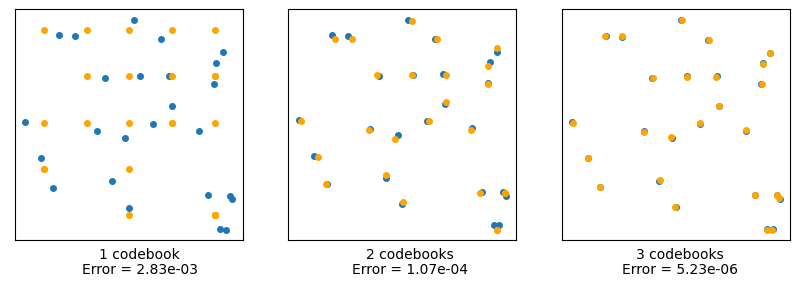

In [ ]:
#| code-fold: true
#| code-summary: "Show the code"
#| label: fig-rvq-recon
#| fig-cap: "Reconstructing data (blue points) using multiple levels of RVQ codebooks (orange dots)"

K = n_codebooks
fig, ax_all = plt.subplots(nrows=1, ncols=K, figsize=(10+(K-3),3))
recon = data*0
for axi in range(K):
    ax = ax_all[axi]
    ax.scatter(data[:, 0], data[:, 1], s=16)
    recon += codebooks[axi][indices[axi]]
    ax.scatter(recon[:, 0], recon[:, 1], s=16, color='orange')
    ax.set_xticks([])
    ax.set_yticks([])
    hpos = 1/K*0.85 + 1/K*0.81*axi if K==4 else .25 + .27*axi
    fig.text(hpos, .05, f"{axi+1} codebook{'s' if axi>0 else ''}", ha='center')

    error = ((recon - data)**2).mean()
    fig.text(hpos, .0001, f"Error = {error:.2e}", ha='center')
    
plt.show()

We see that the more (levels of) codebooks we use, the better we can approximate the original data. The rightmost image has an effective resolution of $5^3 = 125$ little squares, but instead uses only $5x5x3 = 75$. In two dimensions, this is not a huge savings, but let's see how important this is for higher numbers of dimensions. 

Let $d$ be the number of dimensions and $K$ be the number of codebooks (no relation to the k from k-Means, I'm afraid). We'll populate a d-dimensional hypercube with a lot of data, and subdivide it into nested groups of little hypercubes using RVQ, and compute the error -- as well as the compuational cost "savings" from if we had used regular VQ instead of RVQ.

:::{.callout-note}
Using uniform square/(hyper)cube regions is a *really dumb* idea for this. Because the number of regions will scale like `n_grid`$^d$, which can actually be *much* larger than the number of data vectors we have! We'll try a more sophisticated partitioning scheme further below. 
:::

In [ ]:
#| code-fold: true
#| code-summary: "Show the code"
#### label: fig-rvq-recon-highdim2
#### fig-cap: "Error for high-dimensional datasets using various levels of RVQ. 'cost savings factor' refers to the ratio of using regular VQ (at uniform resolution) vs RVQ"

d_choices = [2, 3, 4, 6]  # we can't go much higher with 5x5 uniform grids!
K_choices = [1,2,3,4]     # variable numbers of codebooks

npoints_hd = 1000  # points in high-dim spaces

print("Here we show the error for high-dimensional datasets using various levels of RVQ.")
print("'cost savings factor' refers to the ratio of using regular VQ (at uniform resolution)\nvs RVQ.")

for d in d_choices:
    print(f"\nd = {d}:")
    np.random.seed(1)
    data_hd = DATA_MIN + (DATA_MAX-DATA_MIN)*np.random.rand(npoints_hd, d)
    codebook0 = generate_codebook(n_grid, n_dim=d)
    codebooks = [codebook0/n_grid**level for level in range(max(K_choices))] # lets get this over with rather than in the loop
    for K in K_choices: 
        indices = quantizer(data_hd, codebooks)
        recon = data_hd*0
        for lil_k in range(K):   # reconstruct using all codebooks
            recon += codebooks[lil_k][indices[lil_k]]
        error = ((recon - data_hd)**2).mean()
        grid_0_points = n_grid**(d)
        rvq_points = grid_0_points*K 
        uni_res = grid_0_points**K # comparable uniform resolution
        savings = uni_res/rvq_points
        print(f"  K = {K}, error = {error:.2e}, cost savings factor = {savings:.1f}")
        pass


Here we show the error for high-dimensional datasets using various levels of RVQ.
'cost savings factor' refers to the ratio of using regular VQ (at uniform resolution)
vs RVQ.

d = 2:
  K = 1, error = 3.41e-03, cost savings factor = 1.0
  K = 2, error = 1.29e-04, cost savings factor = 12.5
  K = 3, error = 5.26e-06, cost savings factor = 208.3
  K = 4, error = 2.16e-07, cost savings factor = 3906.2

d = 3:
  K = 1, error = 3.37e-03, cost savings factor = 1.0
  K = 2, error = 1.29e-04, cost savings factor = 62.5
  K = 3, error = 5.31e-06, cost savings factor = 5208.3
  K = 4, error = 2.18e-07, cost savings factor = 488281.2

d = 4:
  K = 1, error = 3.36e-03, cost savings factor = 1.0
  K = 2, error = 1.32e-04, cost savings factor = 312.5
  K = 3, error = 5.34e-06, cost savings factor = 130208.3
  K = 4, error = 2.16e-07, cost savings factor = 61035156.2

d = 6:
  K = 1, error = 3.37e-03, cost savings factor = 1.0
  K = 2, error = 1.33e-04, cost savings factor = 7812.5
  K = 3, error = 5

Those "cost savings factors" were artifically high though, because we're still using squares/hypercubes for our regions, and we don't need to shape them that way and we don't need *that many* of them.  The great thing about (R)VQ is that you can specify how many centroids you want -- i.e. how "long" you want your codebook to be -- and you can keep that to some manageable number even as the number of dimensions skyrockets. 

So, to tackle higher dimensions, we need to stop using uniform squares so we can have a codebook "length" of less than a few thousand centroids (instead of what just had, which was going into the hundreds of thousands, e.g. $5^8 = 390625$). To get our non-uniform regions that follow the data, we'll use the k-Means method described above.   

Let's look at how the reconstruction error behaves in high dimensions. 

### Error Analysis: Exponential Convergence

We can try a given number of (initially) random centroids, and try to match them to the data via k-Means. 

:::{.callout-note}
The residuals at different levels of our RVQ calculations will likely have different data distributions.  Which means that instead of "sharing (scaled) codebooks" like we did before, we'll need to re-calculate a new codebook at each "level". Otherwise we won't see any advantage from RVQ (trust me I tried).
:::

In the following calculation, we'll vary the number of dimensions, the length of the codebooks, and the number of codebooks, and see how these all affect the reconstruction error.

But rather than using our code, use let's use the wonderful repository by lucidrains: [lucidrains/vector-quantize-pytorch](https://github.com/lucidrains/vector-quantize-pytorch)

In [ ]:
#| echo: false
#| output: false
# # Also, for speed, we're ditching numpy for pytorch
# import torch
# import os

# def get_device(gpu_str=''):
#     "utility to suggest which pytorch device to use. from aeoiu.core"
#     device_str = 'cpu'
#     if torch.cuda.is_available():
#         device_str = 'cuda' if gpu_str=='' else f'cuda:{gpu_str}'
#     elif hasattr(torch.backends, 'mps') and torch.backends.mps.is_available(): # must check for mps attr if using older pytorch
#         device_str = 'mps'
#         os.environ['PYTORCH_ENABLE_MPS_FALLBACK'] = '1'
#     return torch.device(device_str)



# def distance_pytorch(p1, p2):
#     "euclidean distance squared. we don't need the square root b/c we're only interested in ordering by distance"
#     return ((p1-p2)**2).sum(1)


# def cluster_membership_pytorch(data, centroids):
#     with torch.no_grad():
#         npoints = data.shape[0]
#         min_ds = 9999*torch.ones(npoints).to(data.device)
#         cluster_memb = torch.zeros(npoints, dtype=int).to(data.device)-1
#         for i, c in enumerate(centroids): # compute distances for all points
#             ds = distance_pytorch(data, c)
#             inds = torch.argwhere(ds < min_ds)
#             if len(inds) > 0: 
#                 min_ds[inds] = ds[inds]
#                 cluster_memb[inds] = i
#         assert len(cluster_memb)==npoints # we're not including the centroids themselves here
#         return cluster_memb

    
# def move_centroids_pytorch(centroids, data, cluster_memb):
#     with torch.no_grad():
#         for ki in range(centroids.shape[0]):
#             inds = torch.argwhere( cluster_memb == ki)
#             if len(inds) > 0:
#                 for dim in range(data.shape[-1]):
#                     centroids[ki,dim] = torch.mean(data[inds,dim], 0)
#     return centroids

# def kmeans_pytorch(data, k=5, n_iter=10):
#     "pytorch version of kmeans routine"
#     with torch.no_grad():
#         n_dim, data_min, data_max = data.shape[-1], torch.min(data), torch.max(data)
#         centroids = data_min + 0.2+0.6*(data_max-data_min)*torch.rand((k, n_dim)).to(data.device) # random init
#         for it in range(n_iter):
#             cluster_memb = cluster_membership_pytorch(data, centroids)
#             centroids = move_centroids_pytorch(centroids, data, cluster_memb)
#     return centroids, cluster_memb

# def new_cb_at_level(resids, cb_len):
#     "given residuals, it will calculate a new codebook for those residuals, and output indices for those codebooks"
#     with torch.no_grad():
#         codebook, indices = kmeans_pytorch(resids, k=cb_len, n_iter=10)
#         new_resids = resids - codebook[indices]  # new_resids are relative to new_codebook
#         return new_resids, codebook, indices


# cpu_device = torch.device('cpu') # turns out cpu is faster on Mac for small/isolated loads
# gpu_device = get_device()


# d_choices = [2, 3, 6, 8, 20, 64, 128, 256]  
# cb_lengths = [25, 64, 256, 1024, 2048]  # codebook lengths
# K_choices = [1,2,3,4, 5]     # variable numbers of codebooks

# #npoints_hd = 10000  # points in high-dim spaces
# npoints_hd = 1024


# results = torch.empty( ( len(d_choices), len(cb_lengths), len(K_choices) )).cpu()

# print("Error values as a function of dimensions (n_dim), codebook length (cb_len),\nand number of codebooks (K):")
# for q1, d in enumerate(d_choices):
#     print(f"\nn_dim ={d:3}:             K=1        K=2        K=3        K=4        K=5")
#     data_hd = DATA_MIN + (DATA_MAX-DATA_MIN)*torch.rand((npoints_hd, d))
    
#     if d >= 64: 
#         cb_lengths = [512, 1024, 2048, 4096]  # codebook lengths for higher-dim spaces
#         K_choices = [4,8,16,32]     # variable numbers of codebooks

#     for q2, cb_len in enumerate(cb_lengths):
#         device = cpu_device #  if d*cb_len < 1e6 else gpu_device  # MPS on M1 is often slower than CPU due to latency
#         data_hd = data_hd.to(device)
#         indent = f"    "
#         print(f"{indent} cb_len = {cb_len:4}:", end="")
#         torch.manual_seed(1)
#         for q3, K in enumerate(K_choices):
#             recon = data_hd*0
#             resids = data_hd
#             for lil_k in range(K):   # loop over codebooks
#                 resids, codebook_l, indices_l = new_cb_at_level(resids, cb_len)
#                 recon += codebook_l[indices_l]
#             error = ((recon - data_hd)**2).mean()
#             print(f"  {error:.2e}{',' if K != K_choices[-1] else ''}",end="")
#             results[q1,q2,q3] = error.cpu()
#         print()

The following set of error values is a "wall of numbers" which may not interest you.  Feel free to scroll past it and skip down to the graphical representation of (some of) the numbers. 

In [ ]:
#| code-fold: true
#| code-summary: "Show the code"

import torch
from vector_quantize_pytorch import ResidualVQ
from functools import partial 

def make_pretty(d,styler):
    styler.set_caption(f"d = {d}:")
    styler.format(lambda e: f'{10**e:0.1e}')   # undo the log op
    styler.background_gradient(axis=None, vmin=-12, vmax=1, cmap="plasma")
    return styler

def show_colored_data(results_d, d, cb_lengths, K_choices):
    "displays a dataframe table but colors the background according to log10 of the numbers"
    rdf = pd.DataFrame(np.log10(results_d.numpy()), 
                       columns=[f'K = {k}' for k in K_choices], 
                       index=[f'cb_len = {c}' for c in cb_lengths])
    ourfunc = partial(make_pretty,d)
    display(rdf.style.pipe(ourfunc))
    return

n_dim = 256  # number of dimensions
cb_len = 256 # codebook length
K = 4        # number of codebooks
npoints_hd = 4096  # number of data points in high-dim space

d_choices = [2, 3, 6, 8, 16, 32, 64, 128, 256, 512]  # dimensions to try
cb_lengths = [25, 64, 256, 1024, 2048]                 # codebook lengths
K_choices = [1,2,3,4,6,8,10]#,16]                           # variable numbers of codebooks

results = torch.empty( ( len(d_choices), len(cb_lengths), len(K_choices) )).cpu()
for q1, n_dim in enumerate(d_choices):
    #print(f"\nd={n_dim:4}:       {' '.join([f'      K={i}' for i in K_choices])}")
    for q2, cb_len in enumerate(cb_lengths):
        #print(f"   cb_len={cb_len:4}: ",end="")
        for q3, K in enumerate(K_choices):
            
            residual_vq = ResidualVQ(
                dim = n_dim,
                codebook_size = cb_len,
                num_quantizers = K,
                kmeans_init = True,   # set to True
                kmeans_iters = 10     # number of kmeans iterations to calculate the centroids for the codebook on init
            )
            torch.manual_seed(0)
            x = torch.randn(1, npoints_hd, n_dim)
            quantized, indices, commit_loss = residual_vq(x)
            error = ((quantized - x)**2).mean()
            #print(f"  {error:.1e} ", end="")
            results[q1,q2,q3] = error
        #print()
    show_colored_data(results[q1], n_dim, cb_lengths, K_choices)     
        

,K = 1,K = 2,K = 3,K = 4,K = 6,K = 8,K = 10
cb_len = 25,7.5e-02,6.8e-03,8.9e-04,1.2e-04,4.8e-06,1.1e-07,2.6e-09
cb_len = 64,3.1e-02,1.7e-03,1.3e-04,1.3e-05,2.1e-07,3.5e-09,6.9e-11
cb_len = 256,8.5e-03,1.9e-04,7.4e-06,4.5e-07,3.1e-09,1.8e-11,1.5e-13
cb_len = 1024,2.0e-03,2.4e-05,9.6e-07,6.1e-08,9.4e-11,4.8e-14,3.5e-15
cb_len = 2048,6.0e-04,1.8e-06,3.9e-08,7.8e-10,1.4e-12,3.8e-15,1.4e-15


,K = 1,K = 2,K = 3,K = 4,K = 6,K = 8,K = 10
cb_len = 25,1.8e-01,3.5e-02,7.7e-03,1.8e-03,1.3e-04,1.0e-05,9.1e-07
cb_len = 64,9.8e-02,1.1e-02,1.4e-03,2.2e-04,5.7e-06,2.7e-07,5.8e-09
cb_len = 256,3.6e-02,1.7e-03,9.8e-05,9.6e-06,1.1e-07,1.8e-09,4.2e-11
cb_len = 1024,1.2e-02,2.7e-04,8.0e-06,4.5e-07,1.5e-09,4.2e-12,2.4e-14
cb_len = 2048,4.4e-03,4.7e-05,9.3e-07,2.5e-08,7.5e-12,3.8e-15,1.8e-15


,K = 1,K = 2,K = 3,K = 4,K = 6,K = 8,K = 10
cb_len = 25,4.3e-01,1.9e-01,8.2e-02,3.7e-02,8.6e-03,2.1e-03,5.5e-04
cb_len = 64,3.2e-01,1.0e-01,3.3e-02,1.1e-02,1.3e-03,1.7e-04,2.2e-05
cb_len = 256,1.8e-01,3.2e-02,6.0e-03,1.1e-03,4.0e-05,1.5e-06,5.6e-08
cb_len = 1024,8.0e-02,6.7e-03,5.8e-04,5.0e-05,4.0e-07,3.6e-09,3.0e-11
cb_len = 2048,3.8e-02,1.6e-03,7.9e-05,3.6e-06,1.1e-08,4.5e-11,2.5e-13


,K = 1,K = 2,K = 3,K = 4,K = 6,K = 8,K = 10
cb_len = 25,5.3e-01,2.8e-01,1.5e-01,8.2e-02,2.4e-02,7.7e-03,2.6e-03
cb_len = 64,4.2e-01,1.7e-01,7.4e-02,3.2e-02,6.2e-03,1.2e-03,2.6e-04
cb_len = 256,2.7e-01,7.1e-02,1.9e-02,5.2e-03,3.9e-04,3.0e-05,2.2e-06
cb_len = 1024,1.3e-01,1.8e-02,2.5e-03,3.5e-04,6.6e-06,1.3e-07,2.7e-09
cb_len = 2048,6.6e-02,4.7e-03,3.4e-04,2.8e-05,1.8e-07,1.6e-09,1.5e-11


,K = 1,K = 2,K = 3,K = 4,K = 6,K = 8,K = 10
cb_len = 25,7.3e-01,5.3e-01,3.9e-01,2.8e-01,1.5e-01,7.9e-02,4.2e-02
cb_len = 64,6.4e-01,4.0e-01,2.6e-01,1.6e-01,6.6e-02,2.7e-02,1.1e-02
cb_len = 256,4.9e-01,2.4e-01,1.2e-01,5.6e-02,1.3e-02,3.2e-03,7.8e-04
cb_len = 1024,3.0e-01,9.0e-02,2.7e-02,8.1e-03,7.7e-04,7.6e-05,7.4e-06
cb_len = 2048,1.6e-01,2.8e-02,4.7e-03,7.6e-04,2.7e-05,1.0e-06,3.8e-08


,K = 1,K = 2,K = 3,K = 4,K = 6,K = 8,K = 10
cb_len = 25,8.5e-01,7.2e-01,6.1e-01,5.1e-01,3.7e-01,2.6e-01,1.9e-01
cb_len = 64,7.8e-01,6.1e-01,4.8e-01,3.8e-01,2.3e-01,1.4e-01,8.7e-02
cb_len = 256,6.7e-01,4.4e-01,3.0e-01,2.0e-01,9.0e-02,4.1e-02,1.8e-02
cb_len = 1024,4.6e-01,2.2e-01,1.0e-01,4.7e-02,9.9e-03,2.3e-03,5.1e-04
cb_len = 2048,2.7e-01,7.1e-02,1.9e-02,5.1e-03,4.2e-04,3.6e-05,2.6e-06


,K = 1,K = 2,K = 3,K = 4,K = 6,K = 8,K = 10
cb_len = 25,9.1e-01,8.4e-01,7.6e-01,7.0e-01,5.8e-01,4.8e-01,4.0e-01
cb_len = 64,8.7e-01,7.6e-01,6.7e-01,5.8e-01,4.5e-01,3.5e-01,2.7e-01
cb_len = 256,7.9e-01,6.6e-01,5.5e-01,4.5e-01,3.2e-01,2.2e-01,1.5e-01
cb_len = 1024,5.8e-01,3.4e-01,2.0e-01,1.2e-01,4.2e-02,1.5e-02,5.6e-03
cb_len = 2048,3.5e-01,1.2e-01,4.3e-02,1.5e-02,2.4e-03,3.6e-04,5.2e-05


,K = 1,K = 2,K = 3,K = 4,K = 6,K = 8,K = 10
cb_len = 25,9.5e-01,9.1e-01,8.6e-01,8.2e-01,7.4e-01,6.7e-01,6.0e-01
cb_len = 64,9.3e-01,8.6e-01,8.0e-01,7.4e-01,6.4e-01,5.6e-01,5.1e-01
cb_len = 256,8.6e-01,7.9e-01,7.2e-01,6.5e-01,5.4e-01,4.4e-01,3.6e-01
cb_len = 1024,6.5e-01,4.7e-01,3.4e-01,2.5e-01,1.3e-01,6.0e-02,2.6e-02
cb_len = 2048,4.1e-01,2.0e-01,9.3e-02,4.4e-02,8.3e-03,1.8e-03,8.4e-05


,K = 1,K = 2,K = 3,K = 4,K = 6,K = 8,K = 10
cb_len = 25,9.7e-01,9.4e-01,9.2e-01,8.9e-01,8.4e-01,8.0e-01,7.5e-01
cb_len = 64,9.5e-01,9.1e-01,8.7e-01,8.4e-01,7.8e-01,7.4e-01,7.1e-01
cb_len = 256,8.9e-01,8.3e-01,7.6e-01,7.0e-01,5.9e-01,5.0e-01,4.2e-01
cb_len = 1024,6.9e-01,5.2e-01,3.8e-01,2.8e-01,1.5e-01,7.8e-02,4.4e-02
cb_len = 2048,4.4e-01,2.2e-01,1.1e-01,5.2e-02,1.2e-02,2.3e-03,2.6e-04


,K = 1,K = 2,K = 3,K = 4,K = 6,K = 8,K = 10
cb_len = 25,9.8e-01,9.7e-01,9.5e-01,9.3e-01,9.0e-01,8.7e-01,8.4e-01
cb_len = 64,9.7e-01,9.4e-01,9.3e-01,9.1e-01,8.8e-01,8.4e-01,8.0e-01
cb_len = 256,9.1e-01,8.6e-01,7.9e-01,7.3e-01,6.3e-01,5.4e-01,4.6e-01
cb_len = 1024,7.1e-01,5.3e-01,3.9e-01,2.9e-01,1.5e-01,8.2e-02,4.5e-02
cb_len = 2048,4.6e-01,2.2e-01,1.1e-01,5.0e-02,1.2e-02,2.3e-03,6.1e-04


> Clarification: RVQ with K=1 is the same thing a regular VQ. 

In [ ]:
#| code-fold: true
#| code-summary: "Show the code"
#| label: fig-rvq-error-surfacea
#| fig-cap: "(Interactive) Surface plot of reconstruction error for 4 codebooks with various data dimensions and codebook lengths."

import numpy as np
import plotly.graph_objects as go
import plotly.io as pio
pio.renderers.default='notebook'
import plotly.express as px 
from plotly.offline import plot, iplot, init_notebook_mode
import plotly.graph_objs as go
init_notebook_mode(connected=True)
import plotly.graph_objects as go

def plot_results(results, d_choices, cb_lengths, K_choices, log_xy=True, log_z=False, vary_K=False,
                camera=dict( up=dict(x=0, y=0, z=1), center=dict(x=0, y=0, z=-0.2), eye=dict(x=1.3, y=1.3, z=1.25)),
                width=750,):
    y, ylabel = np.array(d_choices), 'd'
    if vary_K:
        x, xlabel = np.array(K_choices), 'K'
        z = results[:,-1,:] 
    else:
        x, xlabel = np.array(cb_lengths), 'cb_len'
        z = results[:,:,3] 
    z, zlabel = z.numpy(), 'error'

    if log_xy:
        if not vary_K: 
            x, xlabel = np.log10(x), f"log10( {xlabel} )"
        y, ylabel = np.log10(y), f"log10( {ylabel} )"
    if log_z:
        z, zlabel = np.log10(z), f"log10( {zlabel} )"

    X, Y = np.meshgrid(x, y)

    fig = go.Figure(data=[go.Surface(x=X, y=Y, z=z, )], )
    fig.update_layout(scene = dict(xaxis_title=xlabel,yaxis_title=ylabel,zaxis_title=zlabel))
    fig.update_layout(template='plotly_dark',
        autosize=False,
        width=width,
        height=400,
        margin=dict(l=20,r=20,b=10,t=20,pad=4),
        #paper_bgcolor="LightSteelBlue",
        scene_camera = camera,
    )
    return fig

fig = plot_results(results, d_choices, cb_lengths, K_choices, log_xy=True, log_z=False)
fig.show()

So as we expect, longer codebooks help, and at higher dimensions, error tends to be larger.

Here's the same thing but with a logarithm axis for the error:

In [ ]:
#| code-fold: true
#| code-summary: "Show the code"
#| label: fig-rvq-error-surfacea-logz
#| fig-cap: "(Interactive) Surface plot of reconstruction error for 4 codebooks with various data dimensions and codebook lengths. (Logarithmic z-axis)"
camera=dict( up=dict(x=0, y=0, z=1), center=dict(x=-0.15, y=0, z=-0.2), eye=dict(x=1.2, y=-1.4, z=1))
fig = plot_results(results, d_choices, cb_lengths, K_choices, log_xy=True, log_z=True, camera=camera)
fig.show()

And now let's look at the error for a codebook length of 2048, where we vary the number of codebooks:

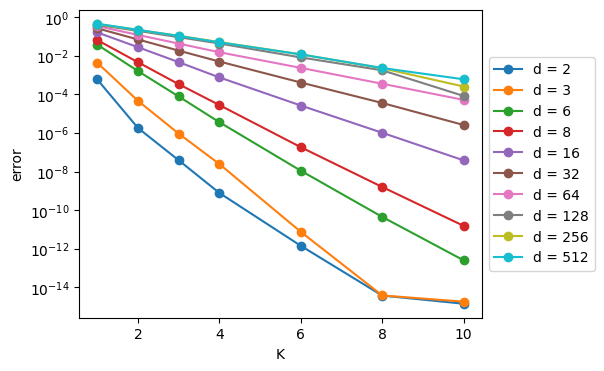

In [ ]:
#| code-fold: true
#| code-summary: "Show the code"
#| label: fig-rvq-error-logz-varyK
#| fig-cap: "Reconstruction error for codebook length of 2048 with various data dimensions and number of codebooks (K). (Logarithmic z-axis)"
#| fig-subcap: 
#|   - "(Interactive) 3D Surface Plot"
#|   - "Line plot"
#| layout-nrow: 2

camera=dict( up=dict(x=0, y=0, z=1), center=dict(x=-0.1, y=0, z=-0.22), eye=dict(x=0.3, y=-1.8, z=1))
fig = plot_results(results, d_choices, cb_lengths, K_choices, vary_K=True, log_xy=True, log_z=True, camera=camera)
fig.show()

fig, ax = plt.subplots(figsize=(6.5,4))
ourdata = results[:,-1,:] # max cb_len
for q1, d in enumerate(d_choices):
    x = np.array(K_choices)
    y = ourdata[q1]
    ax.semilogy(x,y,'o-',label=f"d = {d}")
    
box = ax.get_position()
ax.set_position([box.x0, box.y0, box.width * 0.8, box.height])
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
ax.set_xlabel("K")
ax.set_ylabel("error")
plt.show()

Note that in the last figure, we see **straight lines**[^1] across as we vary K, and the K-axis is linear and the error axis is logarithmic.$^*$ What this means is -- and this is a major takeway:  


::: {.callout-tip}
## Big Idea

**As we add codebooks to the RVQ algorithm, the error decreases *exponentially*!**  
:::

This is a big "selling point" for the RVQ method: you get an *exponential* payoff in error reduction for a *linear* increase in computational cost.


[^1]:Yes, the lines flatten out when we reach machine precision of $10^{-15}$; don't worry about that.


# Addendum: Difficulty at Very High Dimensions
However, the above results also indicate that, for very high dimensions (say, $d \geq 128$), (R)VQ doesn't offer nearly as big of a payoff as is does for lower dimensions -- adding more and larger codebooks doesn't have *that much* of an effect on the errors. 

For this reason, in their *brand new*[^2] paper "[High-Fidelity Audio Compression with Improved RVQGAN](https://arxiv.org/abs/2306.06546)", the [Descript](https://www.descript.com/) team choose to project down to a lower-dimensional space ($d=8$) first, using [Linear](https://pytorch.org/docs/stable/generated/torch.nn.Linear.html) layers, and *then* perform RVQ, and then project back up using another set of Linear Layers. 

[^2]:Brand new" as in "came out while I was finishing this post"!

--- 

...Pausing here for now.  There's more that we could say and do -- for example, "How do you do backpropagation with RVQ?" -- but this seems like a good place to pause this discussion. 

# Acknowledgement 
Thanks to [Zach Evans](https://twitter.com/zqevans) of [Harmonai](https://www.harmonai.org/) for the impetus to look into this topic, and for helpful discussions and corrections while I was writing. 


---

\(c\) 2023 Scott H. Hawley